## A neighborhood-based classification of dog breeds

When I was little, I learned the major groups of dog breeds by heart from a board game that's now apparently [a collector's item](https://www.amazon.com/gp/offer-listing/B00000IZHP/ref=dp_olp_0?ie=UTF8&condition=all). But I've always wondered how much those categories -- sporting dogs, working dogs, non-working dogs -- mean in reality. Are they still the best way to think about different types of dogs today?

As another approach, we could define dog groups by looking at what their owners are like -- using the logic that similar breeds of dogs should be owned by simliar people. Using NYC's detailed dog licensing data, as well as NYC's published demographic data by Neighborhood Tabulation Area (NTA), we will construct a neighborhood-based classification of dog breeds and compare to the established [American Kennel Club categories](https://www.akc.org/public-education/resources/general-tips-information/dog-breeds-sorted-groups/).

This analysis suffers the limitation of being restricted to New York City, so the specific findings may not generalize to all places. However, we still find an observable, and somewhat novel, classifciation of dog breeds in the NYC data, proving the potential usefulness of this method (which would likely be even more powerful in a wider and therefore less homogeneous area). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 20

### 1. Import and clean dog breed ownership data

#### Dog breed cleaning:

In [2]:
# main dataset: registered dogs in NYC with breed and neighborhood information
dog_df = pd.read_csv('data/NYC_Dog_Licensing_Dataset.csv')
dog_df.columns

Index(['RowNumber', 'AnimalName', 'AnimalGender', 'AnimalBirthMonth',
       'BreedName', 'Borough', 'ZipCode', 'CommunityDistrict',
       'CensusTract2010', 'NTA', 'CityCouncilDistrict',
       'CongressionalDistrict', 'StateSenatorialDistrict', 'LicenseIssuedDate',
       'LicenseExpiredDate'],
      dtype='object')

In [3]:
# inspect breed names:
df_breeds = dog_df.groupby("BreedName")['RowNumber'].count().sort_values(ascending=False).reset_index().rename(columns={'RowNumber':'Count'})
df_breeds

,BreedName,Count
0,Unknown,16763
1,Yorkshire Terrier,7773
2,Shih Tzu,7141
3,Chihuahua,5771
4,Maltese,4292
5,Labrador Retriever,4196
6,American Pit Bull Mix / Pit Bull Mix,3401
7,American Pit Bull Terrier/Pit Bull,3341
8,Labrador Retriever Crossbreed,2774
9,Pomeranian,2195


Some cleaning needed, e.g.
- combine some overlapping names (e.g. will group Laborador Retriever Crossbreed and Laborador Retriever together) 
- set cutoff for sample size required to use at each breed
- remove unknowns

In [4]:
# clean breed names:
dog_df['BreedName'] = dog_df['BreedName'].apply(lambda x: str(x).lower()\
                                        .replace(' crossbreed','')\
                                        .replace(', standard', '')\
                                        .replace(' mix','')\
                                        .replace('american pit bull terrier/pit bull','american pit bull / pit bull')\
                                        .replace('bassett hound', 'basset hound')\
                                        .replace('australian cattle dog', 'australian cattledog')\
                                        .replace('german shepherd dog', 'german shepherd')\
                                        .replace('schnauzer, miniature','schnauzer'))\
                                        .replace('bull dog, french', 'french bulldog')\
                                        .replace('welsh corgi, pembroke', 'pembroke welsh corgi')\
                                        .replace('collie, border','border collie')

In [5]:
# set cutoff: arbitrarily try 100 as required sample size
cutoff=100

# inspect breed names:
df_breeds = dog_df.groupby("BreedName")['RowNumber'].count().sort_values(ascending=False).reset_index().rename(columns={'RowNumber':'Count'})
df_breeds['Incl'] = df_breeds['Count'].apply(lambda x: x>=cutoff)

incl_breeds = len(df_breeds[df_breeds['Incl']==True])
dogs_incl = df_breeds[df_breeds['Incl']==True].Count.sum() / df_breeds.Count.sum()

print("# breeds: " +str(incl_breeds))
print("% of dogs included: " + str(dogs_incl))

# breeds: 91
% of dogs included: 0.9670436001935235


100 seems reasonable sample size, and cuts off long tail of breeds while keeping 95%+ of sample

In [6]:
# remove long tail and unknowns:
df_known = dog_df[dog_df['BreedName']!="unknown"]
df_known = df_known.merge(df_breeds[['BreedName','Incl']], how='left', on='BreedName')
df_known = df_known[df_known['Incl']==True].drop('Incl', axis=1)

In [7]:
# view breeds:
df_known['BreedName'].sort_values().unique()

array(['akita', 'american bully', 'american eskimo dog',
       'american pit bull / pit bull', 'american staffordshire terrier ',
       'australian cattledog', 'australian shepherd', 'basenji',
       'basset hound', 'beagle', 'belgian malinois',
       'bernese mountain dog', 'bichon frise', 'border collie',
       'border terrier', 'boston terrier', 'boxer', 'brittany spaniel',
       'brussels griffon', 'bull dog, english', 'bull terrier', 'bulldog',
       'cairn terrier', 'cane corso', 'cavalier king charles spaniel',
       'chihuahua', 'chow chow', 'cocker spaniel', 'collie',
       'cotton de tulear', 'dachshund', 'dachshund smooth coat',
       'dachshund smooth coat miniature', 'dachshund, long haired',
       'dachshund, long haired miniature', 'dalmatian',
       'doberman pinscher', 'english cocker spaniel', 'french bulldog',
       'german shepherd', 'golden retriever', 'goldendoodle',
       'great dane', 'greyhound', 'havanese', 'italian greyhound',
       'jack russe

### 2. Import and select demographic variables

In [8]:
# investigate different levels of geographic granularity in dog dataset:
print("Zips: " + str(len(df_known['ZipCode'].unique())))
print("NTAs: " + str(len(df_known['NTA'].unique())))
print("Comms: " + str(len(df_known['CommunityDistrict'].unique())))
print("Censuses: " + str(len(df_known['CensusTract2010'].unique())))

Zips: 336
NTAs: 193
Comms: 64
Censuses: 1308


Census and zip codes are most granular - but demographic data is not available for those definitions

Demographics only available at the NTA and Comm level -> will use NTAs

Data comes in 4 files (demographic, economic, sociologial, housing). Each has 100s of variables (many of which are overlapping) so not feasible to study them all - will instead select a few as candidates for further research based on knowledge of important demographic factors and pre-testing

In [9]:
# Demographic file:
dem_df = pd.read_excel('data/demo_2016acs5yr_nta.xlsx', sheet_name=0)\
                [['GeogName','GeoID','Pop_1E','FemP','PopU181P','Pop65pl1P','Hsp1P','BlNHP','AsnNHP']]

* Pop_1E = total population
* FemP = female pct 
* PopU181P = % of pop under 18 
* Pop65pl1P = % of pop over 65
* Hsp1P = Hispanic/latino %
* BlNHP = Black non-hispanic %
* AsnNHP = Asian non-hispanic %
* (ignore white non-hispanic because it is approximately all others - multiracial is a very small share)

In [10]:
# Economic file: 
econ_df = pd.read_excel('data/econ_2016acs5yr_nta.xlsx', sheet_name=0)\
            [['GeoID','CvLFUEm2P','MnTrvTmE','MdHHIncE','Inc_SNAPP']]

* CvLFUEm2P = Unemployment rate 
* MnTrvTmE = Mean travel time to work 
* MdHHIncE = Median household income 
* Inc_SNAPP = % on food stamps

In [11]:
# Housing file:
hous_df = pd.read_excel('data/hous_2016acs5yr_nta.xlsx', sheet_name=0)\
            [['GeoID','HU1uDP','BltBf39P','OOcHU1P']]

* HU1uDP = % of single-unit housing (plausible proxy for home size) 
* BltBf39P = pre-1940s construction (may be suited for different types of dogs)
* OOcHU1P = % of owner-occupied housing (ditto)

In [12]:
# Sociological file:
soc_df = pd.read_excel('data/soc_2016acs5yr_nta.xlsx', sheet_name=0)\
            [['GeoID','Fam1P','FamChU18P','EA_BchDHP','DfHs1P','NtvP']]

* Fam1P: % of family households
* FamChU18P: % of family hh's with children
* EA_BchDHP: % with bachelors' degree or higher
* DfHs1P: % of pop that moved wihtin last year
* NtvP: % US-native population

In [13]:
# merge:
dem_df = dem_df.merge(econ_df, how='left', on='GeoID')\
                .merge(hous_df, how='left', on='GeoID')\
                .merge(soc_df, how='left', on='GeoID')

Inspect population size to see if districts are roughly comparable:

In [14]:
dem_df.sort_values('Pop_1E', ascending=False)

,GeogName,GeoID,Pop_1E,FemP,PopU181P,Pop65pl1P,Hsp1P,BlNHP,AsnNHP,CvLFUEm2P,...,MdHHIncE,Inc_SNAPP,HU1uDP,BltBf39P,OOcHU1P,Fam1P,FamChU18P,EA_BchDHP,DfHs1P,NtvP
75,Upper West Side,MN12,134019,55.0,15.8,18.9,16.4,7.2,7.9,5.4,...,99320.0,8.4,0.9,68.4,31.2,44.2,17.9,73.4,16.2,78.0
24,Flatbush,BK42,108653,53.7,24.2,10.8,18.9,45.2,10.2,8.5,...,48896.0,26.0,7.2,59.5,17.5,63.9,29.4,33.5,8.1,55.2
14,Crown Heights North,BK61,107134,55.0,20.6,10.7,12.3,65.9,3.0,9.3,...,40678.0,28.8,1.1,67.0,14.0,52.7,23.2,31.6,10.0,69.1
5,Borough Park,BK88,105913,49.0,39.3,10.1,9.7,0.9,12.9,5.7,...,36893.0,34.9,5.7,57.4,31.2,80.0,44.9,18.8,5.4,73.1
106,Jackson Heights,QN28,104125,49.9,19.0,13.6,56.5,1.8,24.0,6.4,...,53288.0,14.5,3.8,31.7,36.3,62.2,27.8,26.5,7.0,40.3
20,East New York,BK82,94448,54.8,27.5,9.5,27.0,66.2,2.9,11.3,...,35656.0,32.8,3.1,31.5,23.6,67.0,32.8,14.8,6.9,68.3
77,Washington Heights South,MN36,92476,50.1,16.5,12.0,72.9,10.0,3.2,13.0,...,39841.0,38.5,0.8,65.8,6.7,56.0,21.0,28.8,11.3,52.3
4,Bensonhurst West,BK28,91646,51.3,21.0,14.3,14.6,0.9,40.5,8.8,...,51035.0,22.9,5.8,59.9,34.5,73.0,32.0,26.2,9.1,43.9
11,Canarsie,BK50,88367,56.0,22.8,11.7,6.2,84.7,2.8,8.5,...,62263.0,17.2,8.4,17.2,48.7,75.6,31.5,26.0,6.1,54.7
98,Forest Hills,QN17,86531,53.4,18.2,18.1,15.2,2.8,25.6,5.7,...,70278.0,8.1,7.9,23.0,46.0,52.5,21.2,56.7,9.8,52.6


* '99' codes represent miscellaneous categories - not useful here
* '98' codes represent Rikers' Island and LGA/JFK - not relevant here
* Others are normal and within ~an order of magnitude on size -> will proceed with those

In [15]:
dem_df['type'] = dem_df['GeoID'].apply(lambda x: str(x)[-2:])
dem_df = dem_df[dem_df['type']<"98"].drop('type', axis=1)

Many of our demographic variables are likely collinear -> need to narrow down a useful, roughly independent set 

In [16]:
def color_cells(val):
    val = abs(val)
    if val > 0.7:
        color = "red"
    elif val > 0.5:
        color = "orange"
    elif val > 0.3:
        color = "yellow"
    else:
        color = "white"
    return 'background-color: %s' % color

In [17]:
dem_df.corr().style.applymap(color_cells)

,Pop_1E,FemP,PopU181P,Pop65pl1P,Hsp1P,BlNHP,AsnNHP,CvLFUEm2P,MnTrvTmE,MdHHIncE,Inc_SNAPP,HU1uDP,BltBf39P,OOcHU1P,Fam1P,FamChU18P,EA_BchDHP,DfHs1P,NtvP
Pop_1E,1,-0.0343639,-0.00209034,-0.187659,0.0652407,0.0608426,0.00204267,0.0472548,-0.147869,-0.0646313,0.0877599,-0.359661,0.343881,-0.30195,-0.163383,-0.0768033,0.0559804,0.134416,-0.136654
FemP,-0.0343639,1,-0.0205169,0.307058,-0.20401,0.532343,-0.29685,0.222614,0.219026,-0.0566981,0.108893,-0.0680814,-0.275379,-0.036566,-0.106729,-0.154785,0.0242095,-0.0546369,0.175856
PopU181P,-0.00209034,-0.0205169,1,-0.456172,0.390251,0.287408,-0.307786,0.481177,0.447554,-0.602686,0.662344,0.0339362,0.0898174,-0.16373,0.651532,0.897558,-0.73167,-0.516897,-0.00480212
Pop65pl1P,-0.187659,0.307058,-0.456172,1,-0.490072,-0.190364,0.197065,-0.354894,0.0288385,0.33512,-0.443606,0.28024,-0.484738,0.491684,-0.0783057,-0.430169,0.320143,-0.186776,-0.0108078
Hsp1P,0.0652407,-0.20401,0.390251,-0.490072,1,-0.0605765,-0.235982,0.540101,0.144264,-0.593847,0.671441,-0.34659,0.255029,-0.568788,0.133227,0.411958,-0.53842,-0.00114542,-0.181653
BlNHP,0.0608426,0.532343,0.287408,-0.190364,-0.0605765,1,-0.445465,0.467456,0.473448,-0.30162,0.325272,0.0725856,0.0236362,-0.10657,0.163308,0.140496,-0.374636,-0.242109,0.0186448
AsnNHP,0.00204267,-0.29685,-0.307786,0.197065,-0.235982,-0.445465,1,-0.318444,-0.0710678,0.114594,-0.337868,0.119743,-0.159213,0.203414,0.104992,-0.111298,0.12489,0.0477373,-0.5608
CvLFUEm2P,0.0472548,0.222614,0.481177,-0.354894,0.540101,0.467456,-0.318444,1,0.453605,-0.707905,0.774479,-0.199358,0.146698,-0.484627,0.222037,0.379731,-0.626765,-0.129869,-0.129924
MnTrvTmE,-0.147869,0.219026,0.447554,0.0288385,0.144264,0.473448,-0.0710678,0.453605,1,-0.466892,0.297316,0.368421,-0.221719,0.217972,0.700021,0.537014,-0.682499,-0.645021,-0.329389
MdHHIncE,-0.0646313,-0.0566981,-0.602686,0.33512,-0.593847,-0.30162,0.114594,-0.707905,-0.466892,1,-0.842704,0.286456,-0.120629,0.565472,-0.340872,-0.490023,0.813206,0.384363,0.368723


* Household income, food stamps, and unemployment highly correlated (not surprising) -> keep only income
* Single-family and owner-occupied housing highly correlated (also not surprising) -> keep only single-family 
* Family households, children households, and (inverse) % moved within last year are highly correlated -> keep only children 
* Education very highly correlated with income and (inverse) % with children (latter is kinda surprising) 
* % with children under 18 correlated to pop share under 18 (duh) 

In [18]:
dem_df = dem_df.drop(['CvLFUEm2P','Inc_SNAPP','OOcHU1P','Fam1P','DfHs1P','EA_BchDHP','FamChU18P'], axis=1)

### 3. Proof of concept analysis

This analysis assumes there are underlying differences in dog ownership across neighborhoods that are explainable by demographics - is that really the case?

In [19]:
# identify most popular dog breed in each NTA
top_dogs = df_known.groupby(['NTA','BreedName'])['RowNumber'].count().reset_index().rename(columns={'RowNumber':'Count'})\
                    .sort_values('Count', ascending=False)\
                    .drop_duplicates(subset='NTA')
#top_dogs.head(10)

In [20]:
# sort by income:
dem_df[['GeogName','GeoID','MdHHIncE']].merge(top_dogs[['NTA','BreedName']], how='left', left_on='GeoID', right_on='NTA')\
                                .drop('NTA',axis=1).sort_values('MdHHIncE', ascending=False)

,GeogName,GeoID,MdHHIncE,BreedName
72,Upper East Side-Carnegie Hill,MN40,155786.0,labrador retriever
50,Battery Park City-Lower Manhattan,MN25,134266.0,labrador retriever
69,SoHo-TriBeCa-Civic Center-Little Italy,MN24,121638.0,labrador retriever
62,Lincoln Square,MN14,121137.0,labrador retriever
71,Turtle Bay-East Midtown,MN19,119688.0,shih tzu
76,West Village,MN23,119593.0,labrador retriever
66,Midtown-Midtown South,MN17,116456.0,chihuahua
58,Gramercy,MN21,116266.0,labrador retriever
7,Brooklyn Heights-Cobble Hill,BK09,116189.0,labrador retriever
37,Park Slope-Gowanus,BK37,113781.0,labrador retriever


Labrador retrievers are the top breed in 8 of top 10 NTAs by income, but none of botton 10; similarly yorkshire terriers are top breed in none of top 10 but 4 of bottom 10

This suggests household income is a predictor of dog breed ownership (and therefore plausibly other variables as well)

Try another example:

In [21]:
# sort by % aged 65+:
dem_df[['GeogName','GeoID','Pop65pl1P']].merge(top_dogs[['NTA','BreedName']], how='left', left_on='GeoID', right_on='NTA')\
                                .drop('NTA',axis=1).sort_values('Pop65pl1P', ascending=False)

,GeogName,GeoID,Pop65pl1P,BreedName
47,West Brighton,BK23,35.3,yorkshire terrier
43,Starrett City,BK93,29.1,yorkshire terrier
72,Upper East Side-Carnegie Hill,MN40,27.8,labrador retriever
97,Ft. Totten-Bay Terrace-Clearview,QN47,25.8,shih tzu
98,Glen Oaks-Floral Park-New Hyde Park,QN44,24.7,labrador retriever
71,Turtle Bay-East Midtown,MN19,22.9,shih tzu
6,Brighton Beach,BK19,22.8,yorkshire terrier
171,North Riverdale-Fieldston-Riverdale,BX22,22.2,shih tzu
157,Co-op City,BX13,22.0,yorkshire terrier
109,Lindenwood-Howard Beach,QN57,21.1,yorkshire terrier


Not as strong a pattern, but older NTAs tend to favor yorkies, whereas younger districts tend to favor labs and pit bulls

### 4. Full analysis

The goal of this analyis is to calculate the average demographics (for relevant variables we have already selected) of each breed's owners across NYC, then identify clusters of simliar breeds

Ideally we would be able to calculate this individual demographic data for each owner, but we do not have that granularity -- so will have to estimate each dog owner's demographics by using the average by NTA. This will make our analysis less roboust (because we lose any intra-NTA-level variation in demographics), but with ~200 different NTAs in NYC and demonstrated variation in dog ownership between them (as demonstrated in the prior section), hopefully we can still find relevant patterns.

#### Standardize and summarize demographic data:

One wrinkle here: Ordinarily we would usually standardize data immediately before clustering to ensure that features do not contribute differently based on different underlying distribution

However, if we summarize demographics by dog breed and then standardize, we assume that all demographic features are distributed equally among dog owners, even when that is not the case

* For example, if dog breed varies dramatically by gender but not by race, we would observe high variance between average female share of dog breeds but low variance in average racial shares -- and it would be incorrect to then standardize mean and variance at that point
* In other words, we want to standardize demographic variables at the NTA level, but not at the dog breed ownership level

Therefore, we will standardize all demographic variables before merging into dog breed dataset

In [22]:
dem_df.columns

Index(['GeogName', 'GeoID', 'Pop_1E', 'FemP', 'PopU181P', 'Pop65pl1P', 'Hsp1P',
       'BlNHP', 'AsnNHP', 'MnTrvTmE', 'MdHHIncE', 'HU1uDP', 'BltBf39P',
       'NtvP'],
      dtype='object')

In [23]:
# Standardize demographic data:
std_dem_df = dem_df.drop(['GeogName','Pop_1E'], axis=1)
    # note: not including population as not relevant for describing average demographics

demvars = list(std_dem_df.columns[1:])

std_dem_df[demvars] = std_dem_df[demvars].apply(lambda x: (x - x.mean())/x.std())

In [24]:
# merge demographic and dog data
dog_dem_df = df_known[['RowNumber','BreedName','NTA']]\
                    .merge(std_dem_df, how='left', left_on='NTA', right_on='GeoID')\
                    .dropna(subset=['GeoID'])\
                    .drop('GeoID', axis=1)

# drop if NTA not found (for 98 and 99 NTA's or if missing data)
dog_dem_df.shape

(98343, 14)

In [25]:
summ_df = dog_dem_df.groupby('BreedName')[demvars].mean()
summ_df.describe()

,FemP,PopU181P,Pop65pl1P,Hsp1P,BlNHP,AsnNHP,MnTrvTmE,MdHHIncE,HU1uDP,BltBf39P,NtvP
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,-0.018511,-0.589978,0.171891,-0.286154,-0.356740,-0.028062,-0.727319,0.724574,-0.279571,0.173378,0.409334
std,0.131022,0.259085,0.175726,0.171434,0.142952,0.090803,0.375344,0.384944,0.167863,0.160076,0.190554
min,-0.434032,-1.329902,-0.155804,-0.631104,-0.572089,-0.304190,-1.772537,-0.197860,-0.727944,-0.256105,0.051677
25%,-0.077910,-0.796071,0.046379,-0.400192,-0.454479,-0.086785,-0.993858,0.423864,-0.410238,0.036020,0.246860
50%,-0.032410,-0.618173,0.132725,-0.274145,-0.384569,-0.030418,-0.718485,0.682738,-0.278517,0.160614,0.397948
75%,0.038857,-0.404937,0.251221,-0.177286,-0.285448,0.030043,-0.449824,0.979194,-0.167677,0.292984,0.532971
max,0.422460,0.111744,0.821613,0.243503,0.134112,0.244567,0.108257,1.668207,0.154713,0.586338,0.890287


Dog breed ownership varies most strongly by income (stdev of MdHHIncE across dog breeds is 40% of stdev across NTAs) and least strongly by Asian population (stdev of AsnNHP across dog breeds is 10% of stdev across NTAs)

But overall all variables are in a reasonable range of variance (4x from lowest to highest) so it does not seem any one variable will completely dominate the analysis

We need to center the variables for clustering, but as mentioned above we do not want to standardize variance here

In [26]:
# center variables
summ_df[demvars] = summ_df[demvars].apply(lambda x: x - x.mean())
#summ_df.describe()

#### Perform clustering:

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

The AKC has 7 dog groups, so we will restrict ourselves to a range of +/- 2 from that (5-9 groups) in deciding how many groups to assign -- within that range we will select the K with highest silhouette score

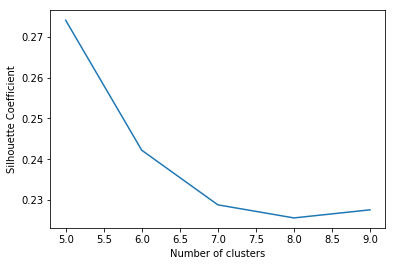

In [28]:
# identify best-fit number of clusters

k_range = range(5,10)

scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=11)
    km_ss.fit(summ_df)
    scores.append(silhouette_score(summ_df, km_ss.labels_))

# select max value:
k_final = k_range[np.argmax(scores)]

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

In [29]:
km_final = KMeans(n_clusters=k_final, random_state=11)
km_final.fit(summ_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=11, tol=0.0001, verbose=0)

In [30]:
breed_groups = pd.DataFrame(list(zip(summ_df.index, km_final.labels_)), columns=['BreedName','Group'])

# check balance of breed groups:
breed_groups.groupby('Group')['BreedName'].count()

Group
0     8
1    19
2    29
3    11
4    23
Name: BreedName, dtype: int64

Groups are fairly balanced

#### Sanity check:

There are several similar breeds in our data set (e.g. multiple types of dachsund) -- do they tend to show up in the same groups?

In [31]:
breed_groups[breed_groups['BreedName'].str.contains('dachshund')]

,BreedName,Group
30,dachshund,2
31,dachshund smooth coat,2
32,dachshund smooth coat miniature,1
33,"dachshund, long haired",2
34,"dachshund, long haired miniature",1


In [32]:
breed_groups[breed_groups['BreedName'].str.contains('schnauzer')]

,BreedName,Group
54,miniature schnauzer,2
71,schnauzer,2


In [33]:
breed_groups[breed_groups['BreedName'].str.contains('greyhound')]

,BreedName,Group
43,greyhound,1
45,italian greyhound,1


In [34]:
breed_groups[breed_groups['BreedName'].str.contains('poodle')]

,BreedName,Group
62,poodle,2
63,"poodle, miniature",2
64,"poodle, toy",2


These examples pass sanity check -- for example, plausible that both minature dachsunds show up in group 3 and the three other dachsunds show up in group 0

### 5. Analyze each group:

In [35]:
# reindex breed_groups to be able to filter demographics too:
breed_groups = breed_groups.set_index('BreedName')

#### Group 0:

In [36]:
grp = 0

In [37]:
grp_df = summ_df[breed_groups['Group']==grp]

# Breed list:
print(list(grp_df.index))

# Demographic data:
print(grp_df.mean())

['american bully', 'american pit bull / pit bull', 'american staffordshire terrier ', 'cane corso', 'rottweiler', 'shih tzu', 'staffordshire bull terrier', 'yorkshire terrier']
FemP        -0.001550
PopU181P     0.463217
Pop65pl1P   -0.194237
Hsp1P        0.289531
BlNHP        0.308710
AsnNHP      -0.107214
MnTrvTmE     0.590094
MdHHIncE    -0.609212
HU1uDP       0.175808
BltBf39P    -0.099154
NtvP        -0.201367
dtype: float64


Group 0 tends to be ___ [will come up with name / patterns among breeds], and owners are especially young, black/hispanic, and less wealthy

#### Group 1:

In [38]:
grp = 1

In [39]:
grp_df = summ_df[breed_groups['Group']==grp]

# Breed list:
print(list(grp_df.index))

# Demographic data:
print(grp_df.mean())

['australian shepherd', 'border terrier', 'brittany spaniel', 'brussels griffon', 'cavalier king charles spaniel', 'dachshund smooth coat miniature', 'dachshund, long haired miniature', 'french bulldog', 'golden retriever', 'greyhound', 'italian greyhound', 'rhodesian ridgeback', 'scottish terrier', 'weimaraner', 'west high white terrier', 'west highland white terrier', 'wheaton terrier', 'whippet', 'wire fox terrier']
FemP         0.023961
PopU181P    -0.224363
Pop65pl1P    0.060390
Hsp1P       -0.138826
BlNHP       -0.090285
AsnNHP      -0.010800
MnTrvTmE    -0.307203
MdHHIncE     0.296521
HU1uDP      -0.096107
BltBf39P     0.078215
NtvP         0.139489
dtype: float64


Group 1 tends to be _____, characterized by: somewhat whiter, wealthier owners that live closer to work, and less likely to have children

#### Group 2:

In [40]:
grp = 2

In [41]:
grp_df = summ_df[breed_groups['Group']==grp]

# Breed list:
print(list(grp_df.index))

# Demographic data:
print(grp_df.mean())

['australian cattledog', 'basenji', 'basset hound', 'border collie', 'boston terrier', 'bull dog, english', 'cairn terrier', 'cocker spaniel', 'collie', 'dachshund', 'dachshund smooth coat', 'dachshund, long haired', 'great dane', 'jack russell terrier', 'labrador retriever', 'miniature schnauzer', 'papillon', 'pembroke welsh corgi', 'pointer', 'poodle', 'poodle, miniature', 'poodle, toy', 'pug', 'rat terrier', 'schnauzer', 'shar-pei, chinese', 'shetland sheepdog', 'shiba inu', 'terrier']
FemP        -0.035760
PopU181P    -0.009808
Pop65pl1P   -0.036289
Hsp1P        0.010651
BlNHP       -0.023876
AsnNHP       0.024115
MnTrvTmE     0.007525
MdHHIncE    -0.031861
HU1uDP      -0.011318
BltBf39P     0.017625
NtvP        -0.016169
dtype: float64


Group 2 is ___, and is square in the middle of nearly all demographic characteristics

#### Group 3:

In [42]:
grp = 3

In [43]:
grp_df = summ_df[breed_groups['Group']==grp]

# Breed list:
print(list(grp_df.index))

# Demographic data:
print(grp_df.mean())

['bernese mountain dog', 'cotton de tulear', 'english cocker spaniel', 'goldendoodle', 'havanese', 'labradoodle', 'miniature american shepherd', 'norwich terrier', 'portuguese water dog', 'tibetan terrier', 'vizsla']
FemP         0.174732
PopU181P    -0.363785
Pop65pl1P    0.274702
Hsp1P       -0.260494
BlNHP       -0.164383
AsnNHP      -0.072111
MnTrvTmE    -0.613982
MdHHIncE     0.679930
HU1uDP      -0.228825
BltBf39P     0.179139
NtvP         0.323522
dtype: float64


Group 3 tends to be ___, characterized by: especially high-income, white, old, and more female

#### Group 4:

In [44]:
grp = 4

In [45]:
grp_df = summ_df[breed_groups['Group']==grp]

# Breed list:
print(list(grp_df.index))

# Demographic data:
print(grp_df.mean())

['akita', 'american eskimo dog', 'beagle', 'belgian malinois', 'bichon frise', 'boxer', 'bull terrier', 'bulldog', 'chihuahua', 'chow chow', 'dalmatian', 'doberman pinscher', 'german shepherd', 'lhasa apso', 'maltese', 'maltipoo', 'miniature pinscher', 'morkie', 'pekingese', 'pomeranian', 'puggle', 'siberian husky', 'silky terrier']
FemP        -0.057734
PopU181P     0.210576
Pop65pl1P   -0.067951
Hsp1P        0.125131
BlNHP        0.075928
AsnNHP       0.050296
MnTrvTmE     0.332681
MdHHIncE    -0.318064
HU1uDP       0.141951
BltBf39P    -0.138022
NtvP        -0.179530
dtype: float64


Group 4 tends to be _____, characterized by: less white (and especially more hispanic), less wealthy owners that live further from work, and more likely to have children

#### Comparison to existing classification

How do the owner-demographics-based groups compare to the official AKC groups? 

(note that some of the NYC "breeds" are mixes, e.g. goldendoodle - in these cases I have mapped to the closest available AKC group based on the parent breeds and what the final dog looks like)

In [46]:
akc_df = pd.read_csv('data/akc_breeds.csv').set_index('BreedName')

In [47]:
breed_pivot = breed_groups.merge(akc_df, how='left', left_index=True, right_index=True)\
                    .reset_index().groupby(['Group','AKCGroup'])[['BreedName']].count()\
                    .reset_index().rename(columns={'BreedName':'Breeds'})

breed_pivot = breed_pivot.pivot(index='AKCGroup', columns='Group').fillna(0)
breed_pivot

Breeds                    
Group             0    1    2    3    4
AKCGroup                               
herding         0.0  1.0  5.0  1.0  2.0
hound           0.0  5.0  5.0  0.0  2.0
non-sporting    0.0  1.0  6.0  4.0  6.0
sporting        0.0  3.0  3.0  2.0  0.0
terrier         4.0  6.0  5.0  1.0  1.0
toy             2.0  3.0  3.0  1.0  8.0
working         2.0  0.0  2.0  2.0  4.0

In [48]:
from scipy.stats import chisquare
chisquare(breed_pivot, axis=None)

Power_divergenceResult(statistic=61.666666666666664, pvalue=0.00254595594841368)

Our set of groups is not completely independent of AKC groups (p<0.01), but at the same time inspection of the table shows that there are quite a few differences as well -- e.g. in only one AKC group (herding) does a majority of breeds fall into a single one of our groups.

Thus, our demographics-based approach yields some new information about breed similarity that is not captured in existing classifications.

### Reflections

* The outputs of clustering are a bit disappointing -- in practice it seems that the important demographic variables tend to be highly correlated (income, race/ethnicity, location, age to some extent) and so our clusters roughly track five points along the income spectrum
* Still, our analysis yields relevant results: various dog breeds are significantly over/underrepresented in areas with different demographic characteristics
* Furthermore, this approach produces results that differ from existing classifications, suggesting it may be useful in some circumstances
* Owner-level demographics data (rather than neighborhood-level data) might be able to unlock more detailed patterns